##### Imports the required libraries

In [2]:
""" Imports the required libraries """

# import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, MaxPooling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Reshape
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


##### Stores the path of the sensor files in the corresponding list

In [3]:
""" Stores the path of the sensor files in the corresponding list """

base_path = "./data/transformed_data/"
phone_accel_file_paths = []
phone_gyro_file_paths = []
watch_accel_file_paths = []
watch_gyro_file_paths = []

for directories, subdirectories, files in os.walk(base_path):
    for filename in files:
        if "phone" in filename and "accel" in filename:
            phone_accel_file_paths.append(f"{base_path}phone/accel/{filename}")
        elif "phone" in filename and "gyro" in filename:
            phone_gyro_file_paths.append(f"{base_path}phone/gyro/{filename}")
        elif "watch" in filename and "accel" in filename:
            watch_accel_file_paths.append(f"{base_path}watch/accel/{filename}")
        elif "watch" in filename and "gyro" in filename:
            watch_gyro_file_paths.append(f"{base_path}watch/gyro/{filename}")

##### Stores the actual name of each activity in the dictionary

In [4]:
""" Stores the actual name of each activity in the dictionary """

activity_dict= {"A":"Walking",
                "B":"Jogging",
                "C":"Stairs",
                "D":"Sitting",
                "E":"Standing",
                "F":"Typing",
                "G":"Brushing",
                "H":"Eat Soup",
                "I":"Eat Chips",
                "J":"Eat Pasta",
                "K":"Drinking",
                "L":"Eat Sandwich",
                "M":"Kicking",
                "O":"Playing",
                "P":"Dribblinlg",
                "Q":"Writing",
                "R":"Clapping",
                "S":"Folding"}

def get_key(val): 
    for key, value in activity_dict.items(): 
        if val == value: 
            return key 

##### Plots the distribution of data among activities

In [5]:
import seaborn as sns
def plot_distribution(data):
    """ Plots the distribution of data among activities """
    
    activity_df = pd.DataFrame()
    activity_df["Activity"] = [activity_dict[item] for item in np.unique(data['ACTIVITY'])]
    act_percentages = []

    for act in activity_df["Activity"]:
        act_percentages.append(len(data[data["ACTIVITY"] == get_key(act)])/len(data)*100)
    activity_df["Distr. of Data Among Activities %"] = act_percentages
    
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 4))

    act = sns.barplot(x="Activity", y="Distr. of Data Among Activities %", data=activity_df)
    ax.set_xlabel("Activity", fontsize = 14)
    ax.set_ylabel("Distr. of Data Among Activities %", fontsize = 13)
#     ax.set_title("Distribution of Data Among Activities", fontsize = 15)
    plt.xticks(rotation=90);

### Distribution of Data Among Activities

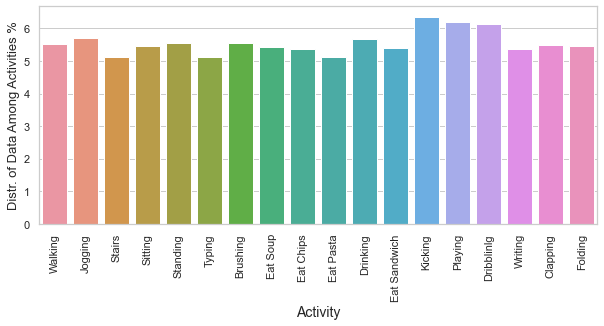

In [7]:
data = pd.read_csv("./data/raw_data/all_data.csv", verbose=False)
plot_distribution(data)

#### The data is slightly imbalanced
#### In order to balance the data, the first 17 data rows of each activity are taken

In [8]:
def balance_data(dataframe):
    """  Takes only the first 17 data rows for each activity """

    A = dataframe[dataframe['ACTIVITY']=='A'].head(17).copy()
    B = dataframe[dataframe['ACTIVITY']=='B'].head(17).copy()
    C = dataframe[dataframe['ACTIVITY']=='C'].head(17).copy()
    D = dataframe[dataframe['ACTIVITY']=='D'].head(17).copy()
    E = dataframe[dataframe['ACTIVITY']=='E'].head(17).copy()
    F = dataframe[dataframe['ACTIVITY']=='F'].head(17).copy()
    G = dataframe[dataframe['ACTIVITY']=='G'].head(17).copy()
    H = dataframe[dataframe['ACTIVITY']=='H'].head(17).copy()
    I = dataframe[dataframe['ACTIVITY']=='I'].head(17).copy()
    J = dataframe[dataframe['ACTIVITY']=='J'].head(17).copy()
    K = dataframe[dataframe['ACTIVITY']=='K'].head(17).copy()
    L = dataframe[dataframe['ACTIVITY']=='L'].head(17).copy()
    M = dataframe[dataframe['ACTIVITY']=='M'].head(17).copy()
    O = dataframe[dataframe['ACTIVITY']=='O'].head(17).copy()
    P = dataframe[dataframe['ACTIVITY']=='P'].head(17).copy()
    Q = dataframe[dataframe['ACTIVITY']=='Q'].head(17).copy()
    R = dataframe[dataframe['ACTIVITY']=='R'].head(17).copy()
    S = dataframe[dataframe['ACTIVITY']=='S'].head(17).copy()

    balanced_data = pd.DataFrame()
    balanced_data = balanced_data.append([A, B, C, D, E, F, G, H, I, J, K, L, M, O, P, Q, R, S], ignore_index=True)

    return balanced_data

##### Takes only 43 important features of the dataframe

In [9]:
def clean_data(dataframe):
    """ Removes the columns "ACTIVITY" and "class" from the dataframe """
    """ Takes only 43 important features of the dataframe  """
    
    df = dataframe.drop(['ACTIVITY', 'class'], axis = 1).copy()
    x1 = df.loc[:, "X0":"ZSTANDDEV"]
    x2 = df.loc[:, 'RESULTANT']   
    cleaned_df = pd.concat([x1, x2], axis=1, join='inner')
    
    return cleaned_df 

##### Normalizes the data using StandardScaler() function

In [10]:
def scale_data(data, labels):
    """ Normalizes the data using StandardScaler() function """

    le = LabelEncoder()
    activity_labels = le.fit_transform(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(data, activity_labels, test_size=0.3, random_state=0)
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

##### Decodes the activity labels and stores them in a dictionary

In [11]:
def activity_dictionary(dataframe):    
    """ Decodes the activity labels and stores them in a dictionary """

    activity_labels = dataframe["ACTIVITY"]
    le = LabelEncoder()
    activity_indices = le.fit_transform(activity_labels)
    mapped_labels = dict(zip(le.transform(le.classes_), le.classes_))
    
    return mapped_labels

##### Preprocesses the data using balance(), clean(), and scale() functions

In [12]:
def preprocess_data(dataframe):
    """ Preprocesses the data using balance(), clean(), and scale() functions """

    balanced_df = balance_data(dataframe)
    activity_labels = balanced_df["ACTIVITY"]
    cleaned_df = clean_data(balanced_df)
    
    return scale_data(cleaned_df, activity_labels)

##### Prints the cross validation report

In [13]:
def crossval_report(accuracy_per_fold, loss_per_fold):
    """ Prints the cross validation report """
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(10):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {accuracy_per_fold[i]} - Accuracy: {loss_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

##### Plots training & validation accuracy values

In [14]:
def plot_learningCurve(history, epochs):
    """ Plots training & validation accuracy values """

    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history["val_accuracy"])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    
    """ Plots training & validation loss values """
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

##### Builds the model (the Convolutional Neural Network)

In [15]:
def get_model():
    """ Builds the model (the Convolutional Neural Network) """
    
    # Defines model
    model = Sequential()
    model.add(Conv1D(filters=43, kernel_size=1, activation='relu', input_shape=(1,43)))
#     model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
#     model.add(Dense(256, activation='relu',name='D1'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax'))

    # Compiles model
    model.compile(optimizer=Adam(learning_rate = 0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

## Phone Accelerometer

In [18]:
""" Phone Accelerometer """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)

phone_accel_accuracy_per_fold={}
phone_accel_loss_per_fold={}

phone_accel_accuracy={}
phone_accel_precision={}
phone_accel_recall={}
phone_accel_f1={}

phone_accel_matrix = {}
phone_accel_activity_accuracy = {}
phone_accel_classification_reports={}

for subjectid, file in enumerate(phone_accel_file_paths[:]):
    subjectid = file.split("_")[2]
    
    data = pd.read_csv(file, verbose=False)
    
    activity_labels = list(activity_dictionary(data).values())
    X_train, X_test, y_train, y_test = preprocess_data(data)
    
    # Makes the input data form 3-Dimensional
    X_train = X_train.reshape(X_train.shape[0], 1, 43)
    X_test = X_test.reshape(X_test.shape[0], 1, 43)
    
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)
        
    acc_per_fold = []
    loss_per_fold = []    
    print("#########################################################################################")
    print(subjectid)
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()
        
        history = model.fit(inputs[train], targets[train], batch_size=1, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1
        
    phone_accel_accuracy_per_fold[subjectid] = acc_per_fold
    phone_accel_loss_per_fold[subjectid] = loss_per_fold
    
    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    phone_accel_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    phone_accel_f1[subjectid] = dict(zip(activity_labels, f1))
    
#     phone_accel_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     phone_accel_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     phone_accel_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

##### The cross validation report

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 94.18181777000427 - Accuracy: 0.3544494605064392%
------------------------------------------------------------------------
> Fold 2 - Loss: 92.36363768577576 - Accuracy: 0.4488078521056609%
------------------------------------------------------------------------
> Fold 3 - Loss: 92.72727370262146 - Accuracy: 0.5173578348891301%
------------------------------------------------------------------------
> Fold 4 - Loss: 92.00000166893005 - Accuracy: 0.5027308412031694%
------------------------------------------------------------------------
> Fold 5 - Loss: 92.00000166893005 - Accuracy: 0.5405109715461731%
------------------------------------------------------------------------
> Fold 6 - Loss: 93.81818175315857 - Accuracy: 0.41282150837508114%
-----------------------------------------------------------------------

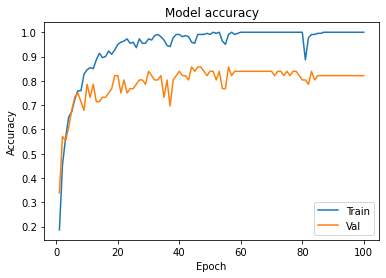

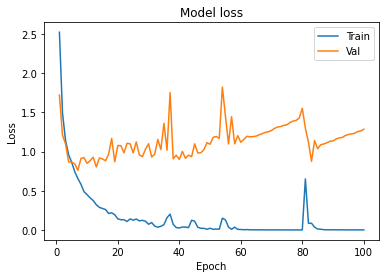

In [15]:
plot_learningCurve(history, 70)

### In order to prevent overfitting, we applied dropout (0.5) before the last layer of the network

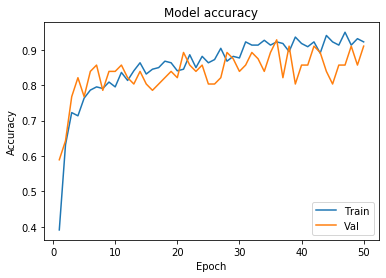

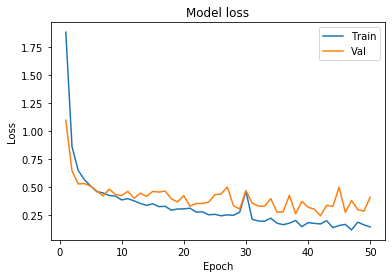

In [30]:
plot_learningCurve(history, 70)

## Phone Gyroscope

In [20]:
""" Phone Gyroscope """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)

phone_gyro_accuracy_per_fold={}
phone_gyro_loss_per_fold={}

phone_gyro_accuracy={}
phone_gyro_precision={}
phone_gyro_recall={}
phone_gyro_f1={}

phone_gyro_matrix = {}
phone_gyro_activity_accuracy = {}
phone_gyro_classification_reports={}

for subjectid, file in enumerate(phone_gyro_file_paths[:]):
    subjectid = file.split("_")[2]
    
    data = pd.read_csv(file, verbose=False)
    
    activity_labels = list(activity_dictionary(data).values())
    X_train, X_test, y_train, y_test = preprocess_data(data)
    
    # Makes the input data form 3-Dimensional
    X_train = X_train.reshape(X_train.shape[0], 1, 43)
    X_test = X_test.reshape(X_test.shape[0], 1, 43)
    
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)
        
    acc_per_fold = []
    loss_per_fold = []    
    
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()
        
        history = model.fit(inputs[train], targets[train], batch_size=1, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[test], targets[test], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1
        
    phone_gyro_accuracy_per_fold[subjectid] = acc_per_fold
    phone_gyro_loss_per_fold[subjectid] = loss_per_fold
    
    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    phone_gyro_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    phone_gyro_f1[subjectid] = dict(zip(activity_labels, f1))
    
#     phone_gyro_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     phone_gyro_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     phone_gyro_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

## Watch Accelerometer

In [23]:
""" Watch Accelerometer """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)

watch_accel_accuracy_per_fold={}
watch_accel_loss_per_fold={}

watch_accel_accuracy={}
watch_accel_precision={}
watch_accel_recall={}
watch_accel_f1={}

watch_accel_matrix = {}
watch_accel_activity_accuracy = {}
watch_accel_classification_reports={}

for subjectid, file in enumerate(watch_accel_file_paths[:]):
    subjectid = file.split("_")[2]
    
    data = pd.read_csv(file, verbose=False)
    
    activity_labels = list(activity_dictionary(data).values())
    X_train, X_test, y_train, y_test = preprocess_data(data)
    
    # Makes the input data form 3-Dimensional
    X_train = X_train.reshape(X_train.shape[0], 1, 43)
    X_test = X_test.reshape(X_test.shape[0], 1, 43)
    
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)
        
    acc_per_fold = []
    loss_per_fold = []    
    
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()
        
        history = model.fit(inputs[train], targets[train], batch_size=1, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[test], targets[test], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1
        
    watch_accel_accuracy_per_fold[subjectid] = acc_per_fold
    watch_accel_loss_per_fold[subjectid] = loss_per_fold
    
    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    watch_accel_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_recall[subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    watch_accel_f1[subjectid] = dict(zip(activity_labels, f1))
    
#     watch_accel_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     watch_accel_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     watch_accel_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))

## Watch Gyroscope

In [26]:
""" Watch Gyroscope """

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)

watch_gyro_accuracy_per_fold={}
watch_gyro_loss_per_fold={}

watch_gyro_accuracy={}
watch_gyro_precision={}
watch_gyro_recall={}
watch_gyro_f1={}

watch_gyro_matrix = {}
watch_gyro_activity_accuracy = {}
watch_gyro_classification_reports={}

for subjectid, file in enumerate(watch_gyro_file_paths[:]):
    subjectid = file.split("_")[2]
    
    data = pd.read_csv(file, verbose=False)
    
    activity_labels = list(activity_dictionary(data).values())
    X_train, X_test, y_train, y_test = preprocess_data(data)
    
    # Makes the input data form 3-Dimensional
    X_train = X_train.reshape(X_train.shape[0], 1, 43)
    X_test = X_test.reshape(X_test.shape[0], 1, 43)
    
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)
        
    acc_per_fold = []
    loss_per_fold = []    
    
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        model = get_model()
        
        history = model.fit(inputs[train], targets[train], batch_size=1, epochs=70, validation_split=0.2, verbose=1)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        scores = model.evaluate(inputs[train], targets[train], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increases fold number
        fold_no = fold_no + 1
        
    watch_gyro_accuracy_per_fold[subjectid] = acc_per_fold
    watch_gyro_loss_per_fold[subjectid] = loss_per_fold
    
    y_true = targets[test]
    y_pred = model.predict_classes(inputs[test], verbose=0)

    # Accuracy: (tp + tn) / (p + n)
    watch_gyro_accuracy[subjectid] = accuracy_score(y_true, y_pred)

    # Precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_precision[subjectid] = dict(zip(activity_labels, precision))

    # Recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_recal [subjectid] = dict(zip(activity_labels, recall))

    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=1)
    watch_gyro_f1[subjectid] = dict(zip(activity_labels, f1))
    
#     watch_gyro_classification_reports[subjectid] = classification_report(y_test, y_pred, zero_division=1)
    
#     matrix = confusion_matrix(y_test, y_pred)
#     watch_gyro_matrix[subjectid] = matrix
    
#     accu_per_class = matrix.diagonal()/ matrix.sum(axis=1)
#     watch_gyro_activity_accuracy[subjectid] = dict(zip(activity_labels, accu_per_class))